In [111]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from qutip import *
from scipy.fft import fft, ifft
from scipy import constants 
from Alk_atom import alk_atom
from PIL import Image

In [282]:
# initialize quantum initial state from "home made" atom class
# preparation state for the MORS in list of [[l,j,[F]]]
myList = [ [0,0.5,[3,4]] , [1,1.5,[3]] ]
my_cesium = alk_atom(myList)
my_cesium.printAtom()
# Load parameters for Caesium alk Library
atom = Caesium()
# energy of D2 line in eV :
E_D2 = atom.getEnergy(6,1,1.5) - atom.getEnergy(6,0,0.5)

# initial field properties for semi-classical simulation
Power = 1e-3 ;          # field power in Watt
S     = (2e-3)*(8e-2)   # insident surface in m^2
phi   = 0               # phase of the field
Delta = 0               # Detuning of the field (rotation frame wl = w0 + Delta , where w0 is D2 line) in Hz
Pol   = [0.5,0.5]       # distribution of polarization state [% of sigma+ , % of sigma-]

Bx = 0.1e-3       # Magnetic field along x in T
# constants
muB = constants.physical_constants['Bohr magneton'][0] # Bohr magneton SI units

# normalizing parameters used for the simulation

T = (2*np.pi)*(constants.hbar)/(0.25*muB*Bx)
ea0 = constants.physical_constants['atomic unit of electric dipole mom.'][0]
E0 = np.sqrt((2*Power)/(S*constants.c*constants.epsilon_0)) # field in V/m on atom




23
[[0, 0.5, [3, 4]], [1, 1.5, [3]]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3]
[-3, -2, -1, 0, 1, 2, 3, -4, -3, -2, -1, 0, 1, 2, 3, 4, -3, -2, -1, 0, 1, 2, 3]


In [ ]:
# Define Hermitian Operators for the simulation

# define the adimensioned Atom Hamiltonian
Hs= Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):
    # Hyper fine shift from center of mass in Hz returned from atom.getHFSEnergyShift
    A = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[0]
    B = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[1]
    Hs.data[m,m] = 1
    #(T/(4*np.pi))*(Delta + atom.getHFSEnergyShift(my_cesium.J[m],my_cesium.F[m],A,B))
# define the adimensioned Interaction Hamiltonian

Hint = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):
    if my_cesium.L[m] == 1:
        for j in range(0,my_cesium.N,1):
                    try:
                        # fetching of dopilar coupling coefficient in ea0 unit
                        #atom.getDipoleMatrixElementHFS(from ket , to ket , p )
                        HsigmaUp = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],+1)
                        HsigmaDown = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],-1)
                        
                        # norlalization
                        HsigmaUp    = -(T*ea0/(2*np.pi*constants.hbar))*(np.sqrt(Pol[0])*E0)*HsigmaUp
                        HsigmaDown  = -(T*ea0/(2*np.pi*constants.hbar))*(np.sqrt(Pol[1])*E0)*HsigmaDown

                        # if my_cesium.L[m]==0:
                        if HsigmaUp!=0:
                            Hint.data[j,m] = HsigmaUp + HsigmaDown
                            Hint.data[m,j] = np.conj(HsigmaUp) + np.conj(HsigmaDown)
                        # elif my_cesium.L[m]==1:
                        #     Hint.data[m,j] = 1

                    except: # catch the error returned when to dipolar transistion is defined
                        pass

# time varying term for the interaction Hamiltonian
def Hint_coeff(t,arg):
    return np.cos(0*t) # set to 1 for the time being

# Build time dependent Hamiltonian
H = [Hs,[Hint, Hint_coeff]]

print(my_cesium.M)
print(atom.getDipoleMatrixElementHFS(6,0,0.5,3,-3,6,1,1.5,3,-2,+1))
print(Hint)


In [283]:
# construction of collapse operators
Cops = [Qobj(dims=[[my_cesium.N],[my_cesium.N]]) for i in range(my_cesium.N)] # initializing an empty list

offset = my_cesium.N - my_cesium.N_notground # element to skip the the basis to reach first collapsing ket
for loop in range(0,my_cesium.N_notground,1): # loop on excited states

            # we now distinguish all case for the possible deacays
            if [my_cesium.L[offset+loop] , my_cesium.J[offset+loop] , my_cesium.F[offset+loop]] \
                ==[0,0.5,4]: # F=4 of the ground sate undergoes spin decay and decoherence

                # spin decay
                for j in range(0,offset +loop,1): # loop on all ket lower in energy than the current one
                    gamma = 100 # we set the decay rate in 100 Hz 
                    if my_cesium.F[j]!=4:
                        Cops[loop] = Cops[loop] + \
                        np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()

            elif [my_cesium.L[offset+loop] , my_cesium.J[offset+loop]]==[1,0.5]:
                # radiative decay 6P1/2
                for j in range(0,offset +loop,1): # loop on all ket lower in energy of l=0
                    if my_cesium.L[j]==0:
                        gamma = atom.getStateLifetime(6,1,0.5, temperature=300,includeLevelsUpTo=7)**-1
                        Cops[loop] = Cops[loop] + \
                            np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()
            elif [my_cesium.L[offset+loop] , my_cesium.J[offset+loop]]==[1,1.5]:
                # radiative decay 6P3/2
                for j in range(0,offset +loop,1): # loop on all ket lower energy of l=0
                    if my_cesium.L[j]==0:
                        gamma = atom.getStateLifetime(6,1,1.5, temperature=300,includeLevelsUpTo=7)**-1
                        Cops[loop] = Cops[loop] + \
                            np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()


print(my_cesium.N)


23


In [284]:
# Initial state initialization
# by convention, the order of the basis is that of my_cesium.M
rho0 = Qobj(dims=[[my_cesium.N],[my_cesium.N]])
for i in range(my_cesium.N_notground,my_cesium.N,1): # equidistribution of over all element of the Hilbert base
    rho0 += basis(my_cesium.N,i)*basis(my_cesium.N,i).dag()

rho0 = rho0/rho0.tr() # normalize by trace norm Trace

In [285]:
# Build readout operator

def C(F,m):
  return np.sqrt(F*(F+1)-m*(m+1))

# self construction of Jy operator in hbar unit (Jy is adimensioned)
Jy = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
     Jy+=0.5*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                               + basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )
     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values

# # self construction of Jz operator in hbar unit
Jz = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
    Jz+=-0.5*1j*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                                  - basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )

# Build a projector onto sub-Hilbert Space L = 0 ; F = 3
G3          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(-3,4):
        G3.data[my_cesium.FetchKetIndex([0,0.5,3,i])[0],my_cesium.FetchKetIndex([0,0.5,3,i])[0]] = 1

# Build a projector onto sub-Hilbert Space L = 0 ; F = 4
G4          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(-4,5):
        G4.data[my_cesium.FetchKetIndex([0,0.5,4,i])[0],my_cesium.FetchKetIndex([0,0.5,4,i])[0]] = 1

# Build a projector onto sub-Hilbert Space L = 1 ; F = 3
E3          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(-3,4):
        E3.data[my_cesium.FetchKetIndex([1,1.5,3,i])[0],my_cesium.FetchKetIndex([1,1.5,3,i])[0]] = 1



c:\Users\Maimouna\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [286]:
# Run simulation
opts = Options()
opts.store_states = True
opts.store_final_state = True

t = np.linspace(0, 50, 500) # Define time vector

# collaspe operator list : Cops
output = mesolve( H, rho0 , t , Cops, [G3,G4,E3,G3*Jz,G4*Jy] , options=opts ) # return a list density matrices over time in "output.states"


Text(0, 0.5, 'Tr[rho]')

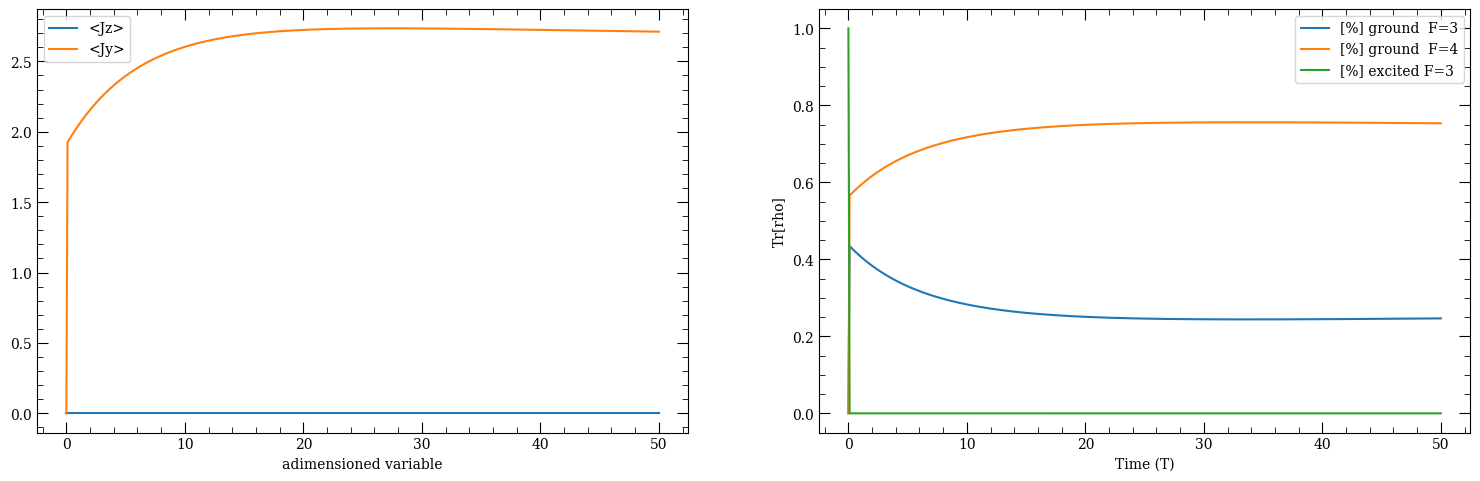

In [287]:
# print(population density on each hyperfine level)
# for i in range(0,len(t)):
#     [i]  = np.real(output.states[i].tr())
    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.5)
ax[0].plot(output.times,output.expect[3],label='<Jz>') 
ax[0].plot(output.times,output.expect[4],label='<Jy>') 
ax[0].set_xlabel('Time (T)') 
ax[0].set_xlabel('adimensioned variable') 
ax[0].legend()
# ax[0].set_xlim(0,3)
ax[1].plot(output.times, output.expect[0],label='[%] ground  F=3') 
ax[1].plot(output.times, output.expect[1],label='[%] ground  F=4') 
ax[1].plot(output.times, output.expect[2],label='[%] excited F=3') 
ax[1].legend()
ax[1].set_xlabel('Time (T)') 
ax[1].set_ylabel('Tr[rho]') 